In [7]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers
import numpy as np
import tensorflow as tf
from keras.applications import vgg19
from transformers import pipeline

base_image_path = "/content/Sherlock.jpg"
style_reference_image_path = "/content/Reference.jpg"
result_prefix = "sherlock_generated"

#Визначається вага компонентів (значення параметрів)
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

#Задаємо розмірність (вимірність) вихідного зображення
width, height = keras.utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

Нейронне перенесення стилю

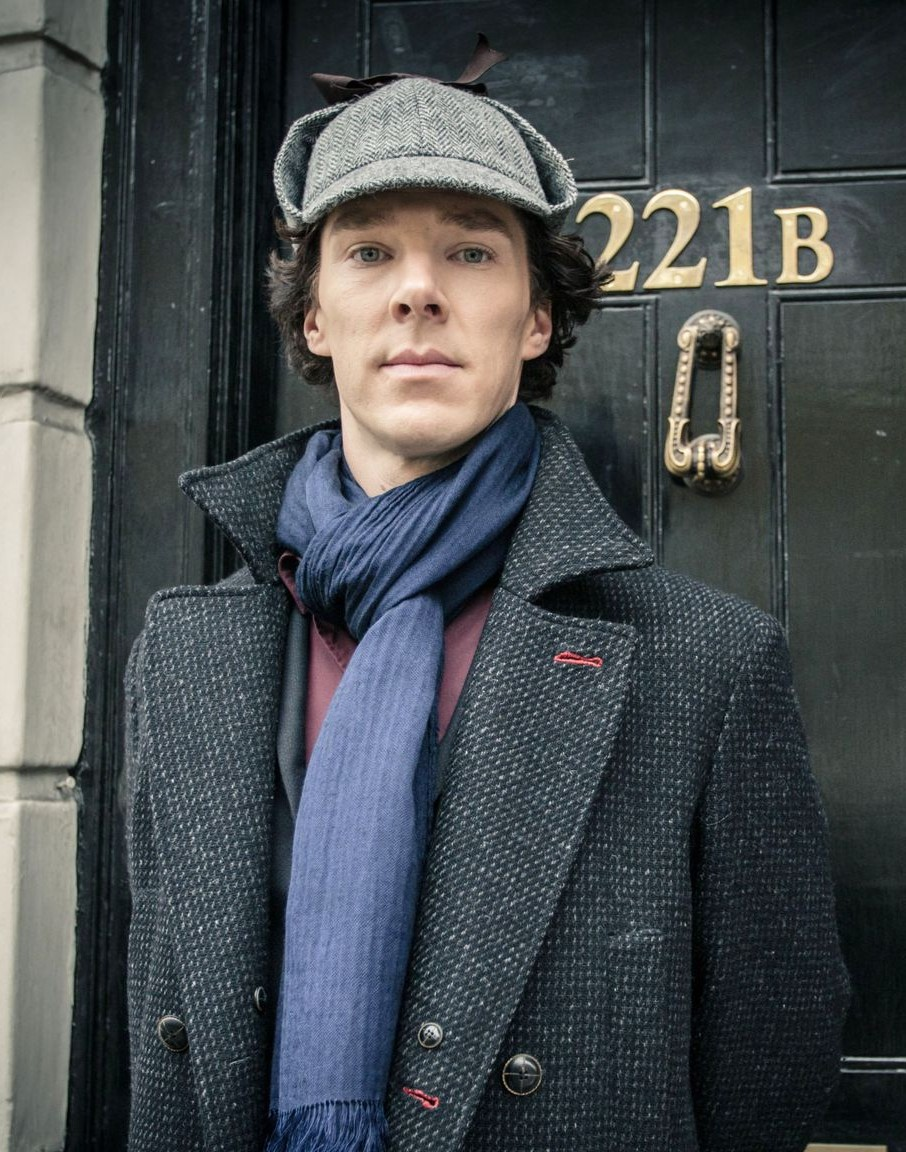

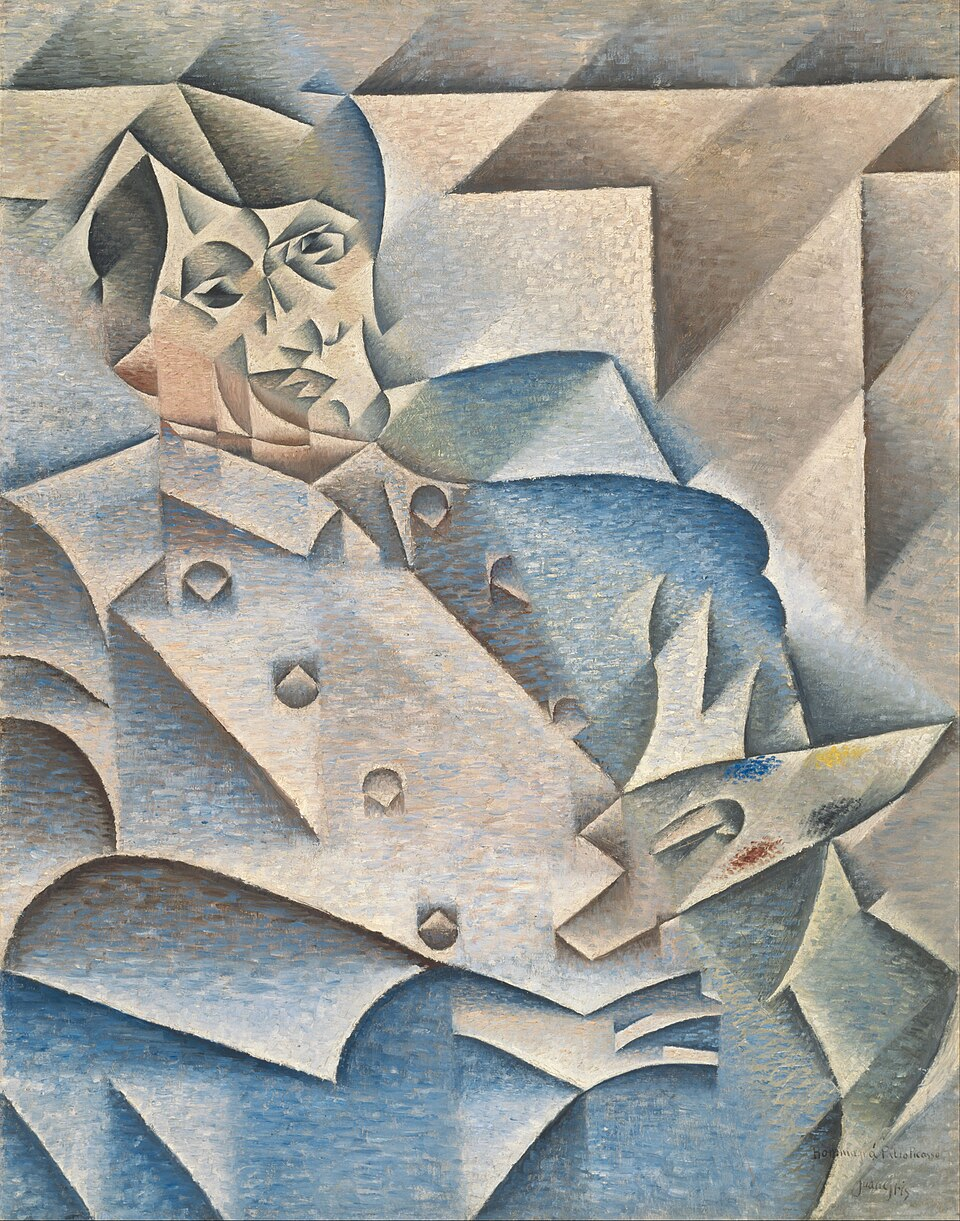

In [8]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

In [9]:
def preprocess_image(image_path):
    # Передобробка зображень: відкриття, зміна розміру, формату дта перетворення їх у тензори (масиви)
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    #Перетворення зображень назад з тензорів у формат фото
    x = x.reshape((img_nrows, img_ncols, 3))
    #Зміщення значень пікселів зображення до середнього значення каналів кольору RGB
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [10]:
#Обчислення матриці Грамма (потрібна для захоплення інформації про текстури та стилі зображення) - потрібна для обрахунку функції втрат стилю
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


#Обрахунок трьох компонент для нашої основної функції Style transfer loss

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))

def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [11]:
#Завантажимо VGG19 яка є попередньо навчена на ImageNet
model = vgg19.VGG19(weights="imagenet", include_top=False)

#Словник який зберігає назви шарів (як ключі) з їх ключами
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

#Створення нової моделі feature_extractor, яка повертає значення активації для кожного шару в базовій моделі model
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [12]:
#Список шарів, які використовуються
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
#Шар який використовуємо для функції content loss
content_layer_name = "block5_conv2"

#Наша основна функція style transfer loss
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    #Її ініціалізація
    loss = tf.zeros(shape=())

    #Додаємо втрату втрату змісту
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    #Додаємо втрату втрату стилю
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    #Додаємо втрату втрату загальної варіації
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [13]:
@tf.function #Цей декоратор перетворює функцію Python у графік TensorFlow. Обраховуємо начення втрат loss і відповідні градієнти grads.
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [14]:
#Зменшуємо швидкість навчання на 0,96 кожні 100 кроків.
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))


#Тренувальний цикл, де застосовуємо градієнтний спуск для мінімізації втрат кожні 50 кроків зберігаємо результат
iterations = 50
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 5 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.utils.save_img(fname, img)

Iteration 5: loss=7612.19
Iteration 10: loss=6079.46
Iteration 15: loss=5250.81
Iteration 20: loss=4614.60
Iteration 25: loss=4174.24
Iteration 30: loss=3843.54
Iteration 35: loss=3579.02
Iteration 40: loss=3362.23
Iteration 45: loss=3179.63
Iteration 50: loss=3024.40


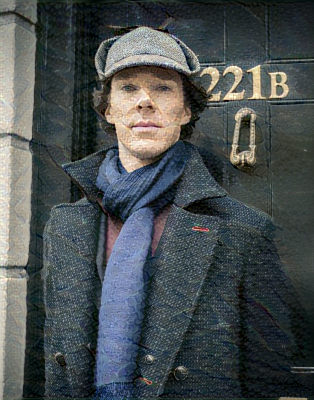

In [15]:
display(Image(result_prefix + "_at_iteration_50.png"))

Pipeline

In [16]:
question_answerer = pipeline("question-answering")
question_answerer(
    question="How is the weather today?",
    context="Today is a rainy day and it is not sunny",
)

No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 564e9b5 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


{'score': 0.2812878489494324, 'start': 11, 'end': 20, 'answer': 'rainy day'}

In [17]:
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-es-en")
translator("Hoy es el día más corto del año.")

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cpu


[{'translation_text': 'Today is the shortest day of the year.'}]

Text Generation with LSTM

In [20]:
import keras
from keras import layers

import numpy as np
import random
import io

In [21]:
path="/content/Lys_mykyta.txt"

Підготуємо дані

In [22]:
with io.open(path, encoding="utf-8") as f:
    text = f.read().lower()
text = text.replace("\n", " ")  #Видаляємо абзаци
print("Corpus length:", len(text))

chars = sorted(list(set(text)))
print("Total chars:", len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

#розрізаємо текст на напівпослідовності довжини maxlen
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])
print("Number of sequences:", len(sentences))

x = np.zeros((len(sentences), maxlen, len(chars)), dtype="bool")
y = np.zeros((len(sentences), len(chars)), dtype="bool")
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Corpus length: 91585
Total chars: 52
Number of sequences: 30515


Будуємо модель (один LSTM шар)

In [23]:
model = keras.Sequential(
    [
        keras.Input(shape=(maxlen, len(chars))),
        layers.LSTM(128),
        layers.Dense(len(chars), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

Підготовлюємо функцію для вибірки текстових фрагментів

In [24]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

Тренування самої моделі

In [25]:
epochs = 5 #5 повних циклів навчання моделі на всіх наявних даних (потрібно мінімум 20 для логічних відповідей)
batch_size = 128 #кількість зразків які одночасно обновляються/обробляються під час навчання

for epoch in range(epochs):
    model.fit(x, y, batch_size=batch_size, epochs=1)
    print()
    print("Generating text after epoch: %d" % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print("...Diversity:", diversity)

        generated = ""
        sentence = text[start_index : start_index + maxlen]
        print('...Generating with seed: "' + sentence + '"')

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.0
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            sentence = sentence[1:] + next_char
            generated += next_char

        print("...Generated: ", generated)
        print("-")

239/239 ━━━━━━━━━━━━━━━━━━━━ 57s 221ms/step - loss: 3.1809

Generating text after epoch: 0
...Diversity: 0.2
...Generating with seed: "а високій чорногорі, де черемош води ско"
...Generated:  робу моробо на соробо зоромов сорового то боробо соробо зоробово воробо воробо соро зоробо зоробо соробо боробо соробо не зоробо морого народо соробо сородо соробо зоробого воров зоробо зороборобо зороборобо соробо соромо зородо соробо моробо дородо сороморово моробо ну соробо зородо соробо зоробо водо мобо боробо моробо залико но зоробо на моров воробо соробо воробо зороборогобо вородо соробо но 
-
...Diversity: 0.5
...Generating with seed: "а високій чорногорі, де черемош води ско"
...Generated:  бо воров якоми сосі мовіло відомо кобороси сороповоно стрине тобе собожу вожи сарі й сарав сос моборогожу що сороже на сороморовороров зороробобобо коробобого порибого соро віхоно нароволи вонодо ні зоромобо тарини! вомосто серу доробув моробо соров но биросторо вовобо до мобав яв і вобо ну з і соро заж